In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import math
from tqdm import trange
import os
from PIL import Image
import torchvision

# Define transformations for training data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Define transformations for safety set (including augmentation)
safety_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
# Load MNIST dataset
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST('./data', train=False, transform=transform)

# Split data into tensors
X_train, Y_train = next(iter(torch.utils.data.DataLoader(
    train_dataset, batch_size=len(train_dataset))))
X_test, Y_test = next(iter(torch.utils.data.DataLoader(
    test_dataset, batch_size=len(test_dataset))))


In [25]:
class QConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(QConv2d, self).__init__()
        self.kernel_size = (kernel_size, kernel_size) if isinstance(
            kernel_size, int) else tuple(kernel_size)
        scale = 1 / math.sqrt(in_channels * math.prod(self.kernel_size))
        self.weight = nn.Parameter(torch.empty(
            out_channels, in_channels, *self.kernel_size).uniform_(-scale, scale))
        self.e = nn.Parameter(torch.full((out_channels, 1, 1, 1), -8.))
        self.b = nn.Parameter(torch.full((out_channels, 1, 1, 1), 32.))  # Start with 32 bits

    def qbits(self):
        return self.b.relu().sum() * self.weight[0].numel()

    def qweight(self):
        b_rel = self.b.relu()
        min_val = torch.where(b_rel > 0, -2 ** (b_rel - 1), torch.zeros_like(b_rel))
        max_val = torch.where(b_rel > 0, 2 ** (b_rel - 1) - 1, torch.zeros_like(b_rel))
        scaled_weight = 2 ** -self.e * self.weight
        qweight = torch.max(torch.min(scaled_weight, max_val), min_val)
        return qweight

    def forward(self, x):
        qw = self.qweight()
        w = (qw.round() - qw).detach() + qw  # Straight-through estimator
        return nn.functional.conv2d(x, 2 ** self.e * w)
        
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.features = nn.Sequential(
            QConv2d(1, 32, 5), nn.ReLU(),
            QConv2d(32, 32, 5), nn.ReLU(),
            nn.BatchNorm2d(32, affine=False, track_running_stats=False),
            nn.MaxPool2d(2),
            QConv2d(32, 64, 3), nn.ReLU(),
            QConv2d(64, 64, 3), nn.ReLU(),
            nn.BatchNorm2d(64, affine=False, track_running_stats=False),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Linear(64 * 3 * 3, 10)  # Adjusted to 64 * 3 * 3

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)
        return x

    def qbits(self):
        return sum(l.qbits() for l in self.features if isinstance(l, QConv2d))


In [26]:
class SafetySetDataset(torch.utils.data.Dataset):
    def __init__(self, safety_set_path, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform
        for file in os.listdir(safety_set_path):
            if file.endswith('.png'):
                label_str = file.split('_label_')[-1].split('.png')[0]
                label = int(label_str)
                image_path = os.path.join(safety_set_path, file)
                self.image_paths.append(image_path)
                self.labels.append(label)
                
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('L')
        if self.transform:
            image = self.transform(image)
        else:
            image = transform(image)  # Default transform
        label = self.labels[idx]
        return image, label


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model().to(device)
opt = optim.Adam(model.parameters())
weight_count = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Load safety set
safety_set_path = "/home/mohammad/Research/Safety-Driven-Self-Compressing-Neural-Networks/safety_set_images_d"  # Update this path if necessary
safety_dataset = SafetySetDataset(safety_set_path, transform=safety_transform)


In [32]:
def train_step():
    model.train()
    opt.zero_grad()
    # Main training batch
    samples = torch.randint(0, X_train.shape[0], (512,))
    outputs = model(X_train[samples].to(device))
    loss = nn.functional.cross_entropy(outputs, Y_train[samples].to(device))
    Q = model.qbits() / weight_count
    loss = loss + 0.1 * Q  # Hyperparameter determines compression vs accuracy

    # Safety set penalty
    # Randomly sample from safety dataset with augmentation
    safety_indices = torch.randint(0, len(safety_dataset), (64,))
    safety_images_batch = []
    safety_labels_batch = []
    for idx in safety_indices:
        img, label = safety_dataset[idx]
        safety_images_batch.append(img)
        safety_labels_batch.append(label)
    safety_images_batch = torch.stack(safety_images_batch).to(device)
    safety_labels_batch = torch.tensor(safety_labels_batch).to(device)
    safety_outputs = model(safety_images_batch)
    safety_loss = nn.functional.cross_entropy(safety_outputs, safety_labels_batch)
    safety_weight = 0.1  # Adjust this weight as needed
    loss = loss + safety_weight * safety_loss

    loss.backward()
    opt.step()
    return loss.item(), Q.item(), safety_loss.item()


In [33]:
def get_test_acc():
    model.eval()
    with torch.no_grad():
        outputs = model(X_test.to(device))
        pred = outputs.argmax(dim=1)
        return (pred == Y_test.to(device)).float().mean().item() * 100

# Safety set without augmentations for evaluation
safety_dataset_eval = SafetySetDataset(safety_set_path, transform=transform)
safety_loader_eval = torch.utils.data.DataLoader(safety_dataset_eval, batch_size=64, shuffle=False)

def get_safety_acc():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in safety_loader_eval:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            pred = outputs.argmax(dim=1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)
    return (correct / total) * 100


In [34]:
def check_zero_bit_kernels():
    for layer in model.features:
        if isinstance(layer, QConv2d):
            if (layer.b.view(-1) <= 0).any():
                return True
    return False

def restore_zero_bit_kernels(restore_fraction=0.5):
    for layer in model.features:
        if isinstance(layer, QConv2d):
            b_flat = layer.b.view(-1)
            zero_bit_indices = (b_flat <= 0).nonzero(as_tuple=False).view(-1)
            num_restore = int(restore_fraction * len(zero_bit_indices))  # Restore half
            if num_restore > 0:
                restore_indices = zero_bit_indices[torch.randperm(len(zero_bit_indices))[:num_restore]]
                b_flat[restore_indices] = 2.0  # Restore bits to 2


In [35]:
# Variables for tracking
prev_safety_acc = None
safety_acc_drop_threshold = 5.0  # Percentage points
test_accs, bytes_used, safety_losses = [], [], []

# Initial safety accuracy
initial_safety_acc = get_safety_acc()
prev_safety_acc = initial_safety_acc

# Training loop
for i in (t := trange(4000)):
    loss, Q, safety_loss = train_step()
    model_bytes = Q / 8 * weight_count
    if i % 10 == 9:
        test_acc = get_test_acc()
        safety_acc = get_safety_acc()
        acc_drop = prev_safety_acc - safety_acc
        if acc_drop > safety_acc_drop_threshold:
            if check_zero_bit_kernels():
                restore_zero_bit_kernels(restore_fraction=0.5)
        prev_safety_acc = safety_acc
    else:
        test_acc = test_accs[-1] if test_accs else 0.0
    test_accs.append(test_acc)
    bytes_used.append(model_bytes)
    safety_losses.append(safety_loss)
    t.set_description(f"loss: {loss:6.2f}  bytes: {model_bytes:.1f}  acc: {test_acc:5.2f}%  safety_loss: {safety_loss:.2f}")


loss:   2.15  bytes: 233832.5  acc: 99.42%  safety_loss: 0.15: 100%|██████████| 4000/4000 [08:45<00:00,  7.61it/s]


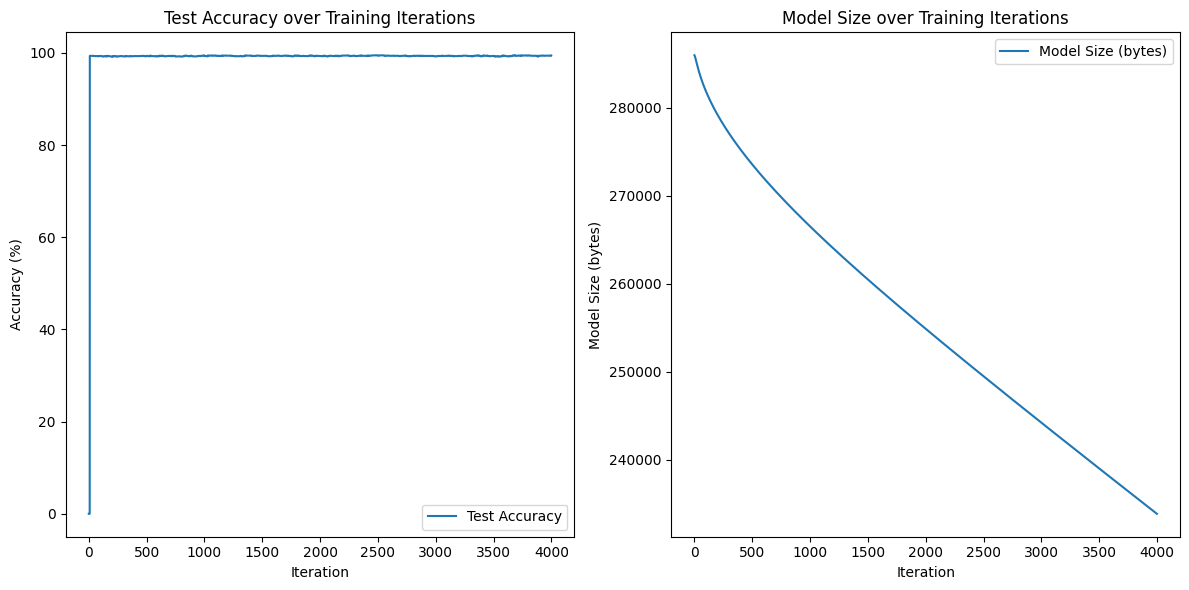

In [36]:
import matplotlib.pyplot as plt

# Plot test accuracy over iterations
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over Training Iterations')
plt.legend()

# Plot model size over iterations
plt.subplot(1, 2, 2)
plt.plot(bytes_used, label='Model Size (bytes)')
plt.xlabel('Iteration')
plt.ylabel('Model Size (bytes)')
plt.title('Model Size over Training Iterations')
plt.legend()

plt.tight_layout()
plt.show()

In [37]:
# Save the model 
torch.save(model.state_dict(), 'modelquantizedfinal.pth') 

In [38]:
# Print final metrics
print(f"Final Test Accuracy: {test_acc:.2f}%")
print(f"Final Safety Accuracy: {safety_acc:.2f}%")
print(f"Initial Safety Accuracy: {initial_safety_acc:.2f}%")
print(f"Final Model Size: {model_bytes:.2f} bytes")
print(f"Total Training Loss: {loss:.4f}")
print(f"Total Q Bits: {Q:.4f}")

Final Test Accuracy: 99.42%
Final Safety Accuracy: 98.40%
Initial Safety Accuracy: 98.50%
Final Model Size: 233832.46 bytes
Total Training Loss: 2.1468
Total Q Bits: 21.2938
